In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
# PRS info
prs_type = 'gm'

# Create PRS data dataframe
file_path = 'data/{}_prs.profile'.format(prs_type)
df = pd.read_csv(file_path, delim_whitespace=True)
df = df[['IID', 'SCORE']]

# Convert SCORE to z-score
df['ZSCORE'] = (df['SCORE'] - df['SCORE'].mean()) / df['SCORE'].std()

# Obrain pTAU data make BID coulmn index and only extract ORRES column
df_ptau = pd.read_csv('data/plasma/biomarker_pTau217.csv', usecols=['BID', 'VISCODE', 'ORRES'])
df_ptau.rename(columns={'ORRES': 'pTau217', 'BID': 'IID'}, inplace=True)
# Keep only those with VISCODE 6
df_ptau = df_ptau[df_ptau['VISCODE'] == 6]
df_ptau.drop(columns=['VISCODE'], inplace=True)
# Convert ptau to float and remove nans
df_ptau['pTau217'] = pd.to_numeric(df_ptau['pTau217'], errors='coerce')
df_ptau.dropna(inplace=True)

# Obtain AB Test data 
df_ab = pd.read_csv('data/plasma/biomarker_AB_Test.csv', usecols=['BID', 'LBTESTCD', 'LBORRES'])
df_ab.rename(columns={'BID': 'IID'}, inplace=True)
ab_test = df_ab['LBTESTCD'].unique()

# Pivot to wide dataframe and remove duplicates
df_ab = df_ab.drop_duplicates(subset=['IID', 'LBTESTCD'], keep='first')
df_ab = df_ab.pivot(index='IID', columns='LBTESTCD', values='LBORRES')
# Convert to floats
df_ab = df_ab.apply(pd.to_numeric, errors='coerce')

# Obtain Plasma Roche measures
df_roche = pd.read_csv('data/plasma/biomarker_Plasma_Roche_Results.csv', usecols=['BID', 'LBTESTCD', 'LABRESN'])
df_roche.rename(columns={'BID': 'IID'}, inplace=True)
plasma_test = df_roche['LBTESTCD'].unique()

# Pivot to wide dataframe and remove duplicates
df_roche = df_roche.drop_duplicates(subset=['IID', 'LBTESTCD'], keep='first')
df_roche = df_roche.pivot(index='IID', columns='LBTESTCD', values='LABRESN')
# Convert to floats
print(df_roche)
df_roche = df_roche.apply(pd.to_numeric, errors='coerce')

# Obtain Cognition data
df_cog = pd.read_csv('data/cognition/PACC.csv', usecols=['BID', 'VISCODE', 'FCTOTAL96'])
df_cog.rename(columns={'BID': 'IID'}, inplace=True)
# Keep only those with VISCODE 001
df_cog = df_cog[df_cog['VISCODE'] == 1]
df_cog.drop(columns=['VISCODE'], inplace=True)


# Merge all dataframes
df = pd.merge(df, df_ptau, on='IID', how='outer')
df = pd.merge(df, df_cog, on='IID', how='outer')
df = pd.merge(df, df_ab, on='IID', how='outer')
df = pd.merge(df, df_roche, on='IID', how='outer')

LBTESTCD  AMYLB40 AMYLB42 APOE4  GFAP  NF-L  TPP181
IID                                                
B10106934   0.191   19.05   NaN  0.195  5.14    NaN
B10139912   0.029    3.97   NaN  0.059  2.03  0.389
B10147592   0.156   13.68   NaN   0.12  2.83  0.962
B10197194   0.214   25.51   NaN  0.049  2.21  0.652
B10256269   0.215   19.37   NaN  0.052  2.42    NaN
...           ...     ...   ...    ...   ...    ...
B99934424   0.201   16.32   NaN    0.1  3.13   1.13
B99955903   0.232   19.83   NaN   0.12  2.83  0.902
B99957366   0.213   17.02   NaN  0.118  2.73   2.21
B99968206   0.164   13.03   NaN  0.063  2.08  0.813
B99971727   0.198   19.15   NaN  0.066  3.16   1.09

[2345 rows x 6 columns]


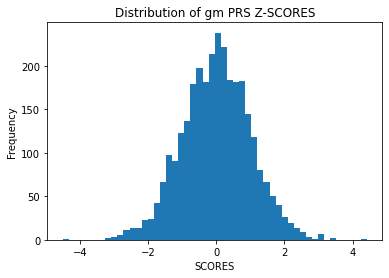

In [3]:
# Show distributions of SCORES
plt.hist(df['ZSCORE'], bins=50)
plt.title('Distribution of {} PRS Z-SCORES'.format(prs_type))
plt.xlabel('SCORES')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Calculate Pearson correlation between PRS and different values
vals = ['pTau217', 'FCTOTAL96'] + ab_test.tolist() + plasma_test.tolist()
for val in vals:
    df_p = df[['ZSCORE', val]].copy().dropna()
    corr, p_val = pearsonr(df_p['ZSCORE'], df_p[val])
    print('[Nº Subjects {}] Correlation between {} PRS and {}: {} ({})'.format(df_p.shape[0], prs_type, val, corr, p_val))


[Nº Subjects 736] Correlation between gm PRS and pTau217: -0.04087102770925425 (0.2681291127477756)
[Nº Subjects 3010] Correlation between gm PRS and FCTOTAL96: -0.02869421500452857 (0.11550264136710177)
[Nº Subjects 2482] Correlation between gm PRS and TP42/TP40: -0.008506945098143679 (0.6718521503293851)
[Nº Subjects 2398] Correlation between gm PRS and FP42/TP42: -0.01947038684730061 (0.3405667893791328)
[Nº Subjects 2572] Correlation between gm PRS and BP40: -0.019470975269532204 (0.3236024878922742)
[Nº Subjects 2600] Correlation between gm PRS and FP40: -0.01220819150618039 (0.533795961815828)
[Nº Subjects 2592] Correlation between gm PRS and TP40: -0.021949065823051915 (0.2639688690304699)
[Nº Subjects 2380] Correlation between gm PRS and BP42: -0.04142534918735684 (0.043305498437351764)
[Nº Subjects 2429] Correlation between gm PRS and FP42/FP40: -0.016977147579452397 (0.402960075574075)
[Nº Subjects 2583] Correlation between gm PRS and FP40/TP40: -0.008673782507461899 (0.65948